In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, when, lit, regexp_replace, count, median, lower, sum
from pyspark.sql.types import StructType, StructField, StringType, LongType, DateType
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

ss = SparkSession.builder \
    .appName("Разработка системы анализа медицинских изображений для эпидемиологического мониторинга COVID-19") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()
ss

In [18]:
df = ss.createDataFrame(pd.read_csv('https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv').replace({np.nan: None})[['patientid', 'age', 'sex', 'finding', 'view', 'date']])
df.printSchema()

df.show(5, 0)

print(f'\nВсего строк - {df.count()}')


root
 |-- patientid: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- finding: string (nullable = true)
 |-- view: string (nullable = true)
 |-- date: string (nullable = true)

+---------+----+---+------------------------+----+----------------+
|patientid|age |sex|finding                 |view|date            |
+---------+----+---+------------------------+----+----------------+
|2        |65.0|M  |Pneumonia/Viral/COVID-19|PA  |January 22, 2020|
|2        |65.0|M  |Pneumonia/Viral/COVID-19|PA  |January 25, 2020|
|2        |65.0|M  |Pneumonia/Viral/COVID-19|PA  |January 27, 2020|
|2        |65.0|M  |Pneumonia/Viral/COVID-19|PA  |January 28, 2020|
|4        |52.0|F  |Pneumonia/Viral/COVID-19|PA  |January 25, 2020|
+---------+----+---+------------------------+----+----------------+
only showing top 5 rows

Всего строк - 950


Пропуски в колонках

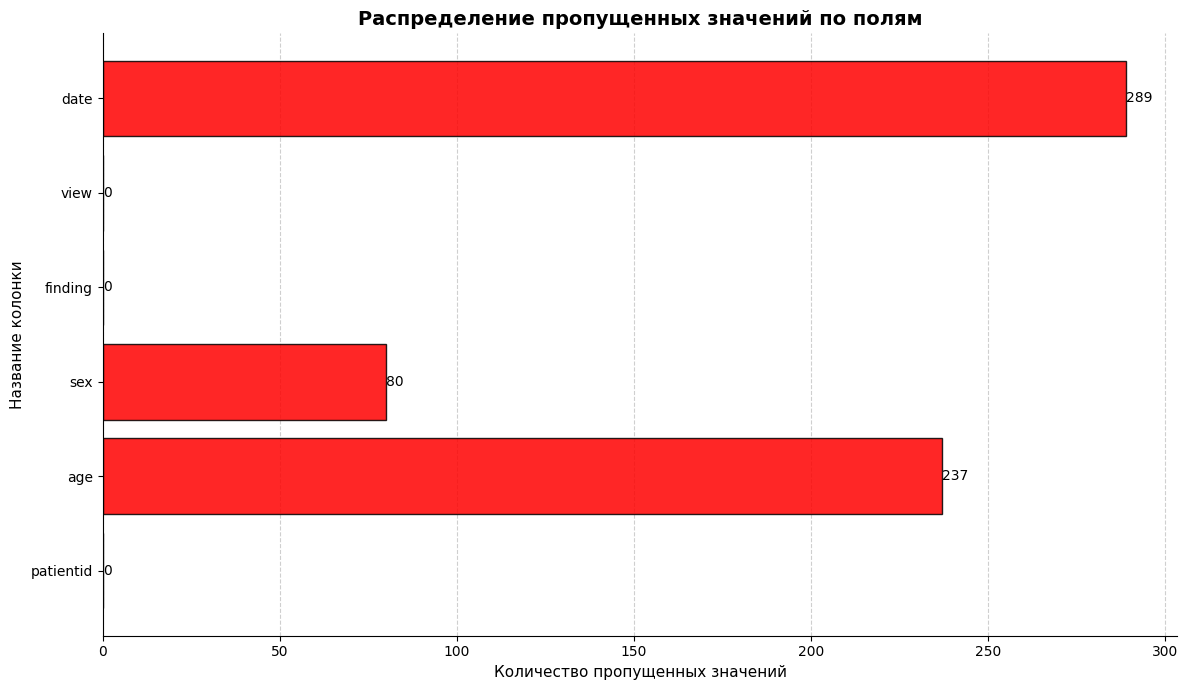

In [19]:
results = []

for column in df.columns:
    cnt_null = (
        df.select(
            sum(
                when(col(column).isNull(), lit(1))
                .otherwise(lit(0))
            )
        )
        .collect()[0][0]
    )
    results.append((column, cnt_null))

df_null = pd.DataFrame(
    results,
    columns=["name_col", "cnt_null"]
)

plt.figure(figsize=(12, 7))

bars = plt.barh(
    df_null["name_col"],
    df_null["cnt_null"],
    color="red",
    edgecolor="black",
    alpha=0.85
)

plt.xlabel("Количество пропущенных значений", fontsize=11)
plt.ylabel("Название колонки", fontsize=11)
plt.title(
    "Распределение пропущенных значений по полям",
    fontsize=14,
    fontweight="bold"
)

plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.gca().set_axisbelow(True)

# Убираем верхнюю и правую рамку
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

for bar in bars:
    width = bar.get_width()
    plt.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{int(width)}",
        va="center",
        ha="left",
        fontsize=10
    )

plt.tight_layout()
plt.show()



Аномалии в колонке age


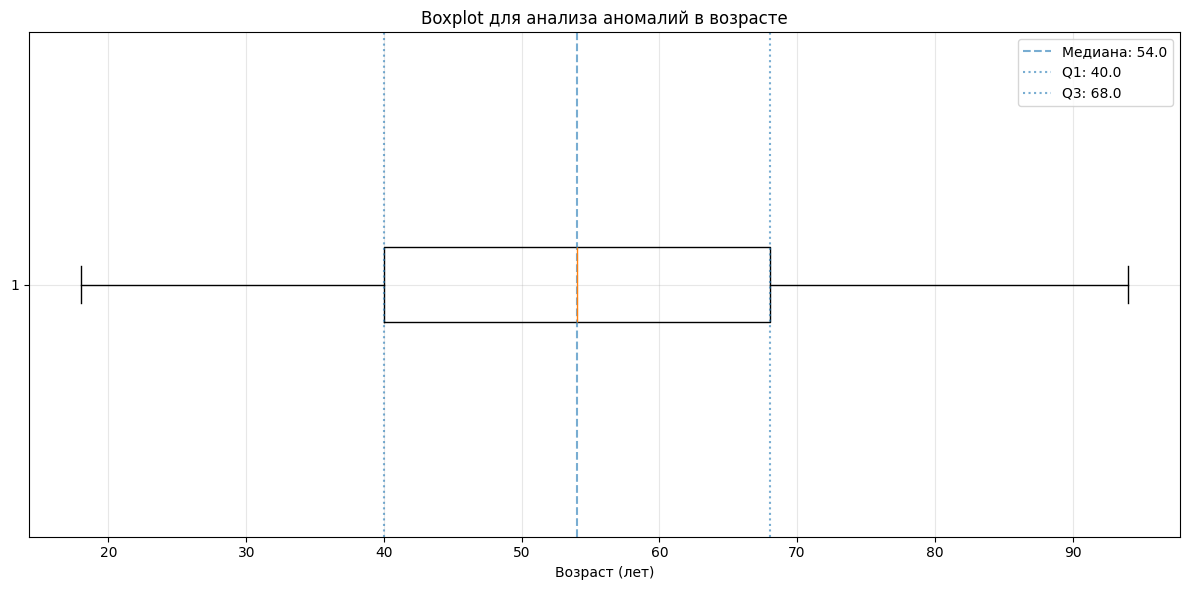

Всего записей с возрастом: 713

Пропущено: 237

Количество выбросов: 0


In [20]:
age = (
    df.select(
        regexp_replace(col("age"), ",", ".")
        .cast("float")
        .alias("age")
    )
    .where(col("age").isNotNull())
    .toPandas()["age"]
)

plt.figure(figsize=(12, 6))
plt.boxplot(age, vert=False)
plt.title("Boxplot для анализа аномалий в возрасте")
plt.xlabel("Возраст (лет)")
plt.grid(alpha=0.3)

median_val = age.median()
q1, q3 = age.quantile([0.25, 0.75])

plt.axvline(median_val, linestyle="--", alpha=0.6, label=f"Медиана: {median_val:.1f}")
plt.axvline(q1, linestyle=":", alpha=0.6, label=f"Q1: {q1:.1f}")
plt.axvline(q3, linestyle=":", alpha=0.6, label=f"Q3: {q3:.1f}")

plt.legend()
plt.tight_layout()
plt.show()

print(f"Всего записей с возрастом: {len(age)}")
print(f"\nПропущено: {df.where(col('age').isNull()).count()}")

iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr

outliers = age[(age < lower) | (age > upper) | (age < 0) | (age > 120)]
print(f"\nКоличество выбросов: {len(outliers)}")



Создаем UDF для категории возраста

In [21]:
def categorize_age(age):
    age = float(age)
    if age < 18:
        return "0-17 (Ребёнок)"
    elif age < 30:
        return "18-29 (Молодой)"
    elif age < 45:
        return "30-44 (Взрослый)"
    elif age < 60:
        return "45-59 (Предпенсионный)"
    elif age < 75:
        return "60-74 (Пенсионер)"
    else:
        return "75+ (Пожилой)"

Анализируем половую принадлежность

In [22]:
df.where(col('sex').isNotNull()).groupBy('sex').count().orderBy(col('count').desc()).show(20, 0)

+---+-----+
|sex|count|
+---+-----+
|M  |559  |
|F  |311  |
+---+-----+



Значения в колонке дата

In [23]:
df.where(col('date').isNotNull()).groupBy('date').count().orderBy(col('count').desc()).show(100, 0)


+------------------+-----+
|date              |count|
+------------------+-----+
|2020              |454  |
|2015              |24   |
|2016              |20   |
|2014              |11   |
|2004              |11   |
|2013              |7    |
|Mar 4, 2020       |6    |
|2018              |6    |
|February 6, 2020  |6    |
|Mar 3, 2020       |5    |
|2011              |5    |
|March 10, 2020    |5    |
|March 2003        |5    |
|January 22, 2020  |4    |
|March 5, 2020     |4    |
|2010              |3    |
|2017              |3    |
|March 4, 2020     |3    |
|January 25, 2020  |3    |
|January 27, 2020  |3    |
|January 31, 2020  |2    |
|December 29, 2019 |2    |
|May 4, 2010       |2    |
|2019              |2    |
|January 19, 2020  |2    |
|March 7, 2020     |2    |
|Feb 21, 2020      |2    |
|January 1, 2020   |2    |
|January 26, 2020  |2    |
|2/29/2020         |2    |
|03/16/20          |2    |
|03/09/20          |2    |
|11/27/19          |2    |
|March 2020        |2    |
|

Создание UDF для парсинга колонки дата

In [24]:
def parse_date(date_str):
    if not date_str:
        return None
    date_str = str(date_str).strip()
    formats = [
        "%B %d, %Y",      # January 22, 2020
        "%b %d, %Y",      # Feb 18, 2020
        "%d %B %Y",       # 12 March 2020
        "%d %b %Y",       # 12 Mar 2020
        "%m/%d/%Y",       # 3/3/2020
        "%m/%d/%y",       # 03/16/20
        "%B %Y",          # March 2003
        "%b %Y",          # Mar 2003
        "%Y",             # 2014
        "%B %d",          # January 12
        "%b %d",          # Feb 18
        "%d %B",          # 12 March
        "%d %b",          # 12 Mar
    ]

    for c in formats:
        try:
            result = datetime.strptime(date_str, c).date()
            if c in ["%B %d", "%b %d", "%d %B", "%d %b"]:
                result = result.replace(year=2020)
            return result
        except:
            continue
    return None

UDF для унификации диагнозов

In [25]:
def unify_finding(finding):
    if finding is None:
        return "Unknown"
    finding_str = str(finding).lower().strip()

    # COVID
    if any(word in finding_str for word in ["covid", "sars-cov-2", "coronavirus", "corona"]):
        return "COVID-19"

    # Все виды пневмоний
    elif "pneumonia" in finding_str:
        return "Pneumonia"

    # ARDS
    elif "ards" in finding_str or "acute respiratory distress" in finding_str:
        return "ARDS"

    # Нормальные случаи
    elif any(word in finding_str for word in ["no finding", "normal", "clear"]):
        return "Normal"

    # Туберкулез
    elif "tuberculosis" in finding_str or "tb" in finding_str:
        return "Tuberculosis"

    # Все остальное
    else:
        # Короткие названия оставляем как есть, длинные упрощаем
        if "/" in finding_str:
            return finding_str.split("/")[0].strip().title()
        elif len(finding_str) > 30:
            return "Other"
        else:
            return finding_str.title()

In [26]:
# Заполнение пропусков в возрасте медианой
median_age = (
    df.where(col("age").isNotNull())
      .agg(median("age").alias("median_age"))
      .first()["median_age"]
)

df = df.withColumn(
    "age",
    when(col("age").isNull(), median_age).otherwise(col("age"))
)

# Заполнение пропусков в поле sex наиболее частым значением
most_common_sex = (
    df.where(col("sex").isNotNull() & (col("sex") != ""))
      .groupBy("sex")
      .count()
      .orderBy(col("count").desc())
      .first()["sex"]
)

df = df.withColumn(
    "sex",
    when(col("sex").isNull(), most_common_sex).otherwise(col("sex"))
)

# Приведение даты к формату и заполнение пропусков
df = df.withColumn(
    "date_parsed",
    udf(parse_date, DateType())(col("date"))
)

most_common_date = (
    df.where(col("date_parsed").isNotNull())
      .groupBy("date_parsed")
      .count()
      .orderBy(col("count").desc())
      .first()["date_parsed"]
)

df = df.withColumn(
    "date_correct",
    when(col("date_parsed").isNotNull(), col("date_parsed"))
    .otherwise(most_common_date)
)

# Категоризация возраста
df = df.withColumn(
    "age_category",
    udf(categorize_age, StringType())(col("age"))
)

# Унификация диагнозов
df = df.withColumn(
    "finding_unified",
    udf(unify_finding, StringType())(col("finding"))
)

# Удаление полных дубликатов и лишних колонок
df = (
    df.dropDuplicates()
      .drop("finding", "date", "date_parsed")
)

df.show(10, truncate=False)


+---------+----+---+---------+------------+----------------------+---------------+
|patientid|age |sex|view     |date_correct|age_category          |finding_unified|
+---------+----+---+---------+------------+----------------------+---------------+
|4        |52.0|F  |PA       |2020-01-25  |45-59 (Предпенсионный)|COVID-19       |
|3        |74.0|M  |AP       |2004-01-01  |60-74 (Пенсионер)     |Pneumonia      |
|7        |29.0|F  |PA       |2004-01-01  |18-29 (Молодой)       |Pneumonia      |
|10       |73.0|F  |AP       |2004-01-01  |60-74 (Пенсионер)     |Pneumonia      |
|13       |35.0|M  |PA       |2020-01-19  |30-44 (Взрослый)      |COVID-19       |
|13       |35.0|M  |PA       |2020-01-24  |30-44 (Взрослый)      |COVID-19       |
|15       |54.0|M  |PA       |2020-01-01  |45-59 (Предпенсионный)|COVID-19       |
|19       |55.0|F  |AP       |2020-01-23  |45-59 (Предпенсионный)|COVID-19       |
|20       |54.0|M  |PA       |2020-01-01  |45-59 (Предпенсионный)|COVID-19       |
|27 

In [27]:
df.createOrReplaceTempView('temp_view')

Строим сводную таблицу по диагнозам, где для каждого диагноза показано:

сколько пациентов,

какой процент от общего числа,

средний возраст,

минимальный и максимальный возраст.

In [33]:
ss.sql("""
    SELECT
        finding_unified,
        COUNT(1) AS patients_cnt,
        ROUND(
            COUNT(1) * 100.0
            / SUM(COUNT(1)) OVER (),
            2
        ) AS pct_total,
        ROUND(AVG(age), 1) AS mean_age,
        MIN(age) AS youngest_age,
        MAX(age) AS oldest_age
    FROM temp_view
    GROUP BY finding_unified
    ORDER BY patients_cnt DESC
""").show(10, truncate=False)


+---------------+------------+---------+--------+------------+----------+
|finding_unified|patients_cnt|pct_total|mean_age|youngest_age|oldest_age|
+---------------+------------+---------+--------+------------+----------+
|COVID-19       |437         |65.42    |55.6    |20.0        |94.0      |
|Pneumonia      |166         |24.85    |49.9    |18.0        |90.0      |
|Todo           |27          |4.04     |54.0    |54.0        |54.0      |
|Normal         |20          |2.99     |53.5    |22.0        |78.0      |
|Tuberculosis   |17          |2.54     |42.4    |20.0        |78.0      |
|Unknown        |1           |0.15     |54.0    |54.0        |54.0      |
+---------------+------------+---------+--------+------------+----------+



считаем распределение диагнозов внутри каждого пола:
сколько пациентов с каждым диагнозом,
какой процент этот диагноз занимает среди мужчин и среди женщин отдельно,
сортирует диагнозы по популярности внутри пола,

Показывает, какие диагнозы чаще встречаются у мужчин и у женщин и в каких долях.

In [32]:
ss.sql("""
    SELECT
        sex,
        finding_unified,
        COUNT(1) AS patients_cnt,
        ROUND(
            COUNT(1) * 100.0
            / SUM(COUNT(1)) OVER (PARTITION BY sex),
            2
        ) AS pct_within_sex
    FROM temp_view
    GROUP BY
        sex,
        finding_unified
    ORDER BY
        sex,
        patients_cnt DESC
""").show(20, truncate=False)


+---+---------------+------------+--------------+
|sex|finding_unified|patients_cnt|pct_within_sex|
+---+---------------+------------+--------------+
|F  |COVID-19       |129         |62.02         |
|F  |Pneumonia      |59          |28.37         |
|F  |Normal         |9           |4.33          |
|F  |Todo           |6           |2.88          |
|F  |Tuberculosis   |5           |2.40          |
|M  |COVID-19       |308         |66.96         |
|M  |Pneumonia      |107         |23.26         |
|M  |Todo           |21          |4.57          |
|M  |Tuberculosis   |12          |2.61          |
|M  |Normal         |11          |2.39          |
|M  |Unknown        |1           |0.22          |
+---+---------------+------------+--------------+



Находим самых возрастных пациентов по каждому диагнозу:
для каждого finding_unified,
выбираем 3 самых старших пациента,
убираем дубликаты по пациенту и диагнозу,
нумеруем пациентов внутри диагноза по возрасту (от старших к младшим)



In [34]:
ss.sql("""
    SELECT
        patientid,
        age,
        sex,
        finding_unified,
        rn AS rank_in_finding
    FROM (
        SELECT
            patientid,
            age,
            sex,
            finding_unified,
            ROW_NUMBER() OVER (
                PARTITION BY finding_unified
                ORDER BY age DESC
            ) AS rn
        FROM temp_view
        GROUP BY
            patientid,
            age,
            sex,
            finding_unified
    )
    WHERE rn <= 3
    ORDER BY
        finding_unified,
        rn
""").show(20, truncate=False)


+---------+----+---+---------------+---------------+
|patientid|age |sex|finding_unified|rank_in_finding|
+---------+----+---+---------------+---------------+
|326b     |94.0|M  |COVID-19       |1              |
|324b     |93.0|F  |COVID-19       |2              |
|200      |88.0|M  |COVID-19       |3              |
|325      |78.0|F  |Normal         |1              |
|315      |78.0|F  |Normal         |2              |
|478      |75.0|F  |Normal         |3              |
|460      |90.0|M  |Pneumonia      |1              |
|91       |80.0|F  |Pneumonia      |2              |
|340      |80.0|M  |Pneumonia      |3              |
|430      |54.0|F  |Todo           |1              |
|431      |54.0|F  |Todo           |2              |
|439      |54.0|M  |Todo           |3              |
|421      |78.0|M  |Tuberculosis   |1              |
|453      |70.0|M  |Tuberculosis   |2              |
|456      |58.0|M  |Tuberculosis   |3              |
|221      |54.0|M  |Unknown        |1         

Строим временную сводку исследований по месяцам и годам:
считает общее количество исследований (count(*)),
считает уникальных пациентов (count(distinct patientid)),
вычисляет средний возраст пациентов,
группирует данные по году и месяцу исследования,
сортирует результат по хронологии.

In [35]:
ss.sql("""
    SELECT
        YEAR(date_correct) AS study_year,
        MONTH(date_correct) AS study_month,
        COUNT(*) AS total_studies,
        COUNT(DISTINCT patientid) AS unique_patients,
        ROUND(AVG(age), 1) AS avg_age
    FROM temp_view
    GROUP BY
        YEAR(date_correct),
        MONTH(date_correct)
    ORDER BY
        study_year,
        study_month
""").show(20, truncate=False)


+----------+-----------+-------------+---------------+-------+
|study_year|study_month|total_studies|unique_patients|avg_age|
+----------+-----------+-------------+---------------+-------+
|2003      |3          |3            |3              |40.7   |
|2004      |1          |5            |5              |52.8   |
|2007      |1          |1            |1              |54.0   |
|2009      |9          |3            |1              |30.0   |
|2010      |1          |3            |2              |54.0   |
|2010      |5          |2            |1              |40.0   |
|2010      |10         |1            |1              |30.0   |
|2011      |1          |3            |2              |46.7   |
|2013      |1          |5            |3              |65.6   |
|2014      |1          |6            |4              |50.7   |
|2015      |1          |11           |8              |56.0   |
|2015      |5          |1            |1              |65.0   |
|2016      |1          |14           |8              |4

Анализируем распределение диагнозов по типу просмотра (view):
считает количество изображений для каждого диагноза в каждом view,
вычисляет процент диагноза относительно всех изображений этого view,
считает средний возраст пациентов для каждой группы,
сортирует по типу view и убыванию числа изображений.

In [36]:
ss.sql("""
    SELECT
        view,
        finding_unified,
        COUNT(*) AS images_count,
        ROUND(
            COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY view),
            2
        ) AS pct_within_view,
        ROUND(AVG(age), 1) AS avg_age
    FROM temp_view
    GROUP BY
        view,
        finding_unified
    ORDER BY
        view,
        images_count DESC
""").show(20, truncate=False)


+---------+---------------+------------+---------------+-------+
|view     |finding_unified|images_count|pct_within_view|avg_age|
+---------+---------------+------------+---------------+-------+
|AP       |COVID-19       |106         |71.62          |58.2   |
|AP       |Pneumonia      |35          |23.65          |52.5   |
|AP       |Normal         |5           |3.38           |60.6   |
|AP       |Tuberculosis   |2           |1.35           |45.5   |
|AP Erect |Pneumonia      |1           |100.00         |30.0   |
|AP Supine|COVID-19       |94          |72.87          |58.2   |
|AP Supine|Todo           |17          |13.18          |54.0   |
|AP Supine|Pneumonia      |15          |11.63          |48.9   |
|AP Supine|Normal         |2           |1.55           |49.5   |
|AP Supine|Unknown        |1           |0.78           |54.0   |
|Axial    |COVID-19       |44          |93.62          |50.2   |
|Axial    |Normal         |3           |6.38           |40.7   |
|Coronal  |COVID-19      

Берём только пациентов с диагнозом COVID-19 и возрастом 60+

Считаем общее число записей в исходном DataFrame

Считаем число записей после фильтрации

In [37]:
# Фильтруем данные: диагноз COVID-19 и возраст ≥ 60
filtered_df = df.filter((col("finding_unified") == "COVID-19") & (col("age") >= 60))

print(f"Общее число записей: {df.count()}")
print(f"После фильтрации (COVID-19, возраст ≥ 60): {filtered_df.count()}")


Общее число записей: 668
После фильтрации (COVID-19, возраст ≥ 60): 156


Сохраняем отфильтрованные данные (filtered_df) в формате Parquet, перезаписывая существующую папку "parquet".

In [38]:
# Сохраняем отфильтрованный DataFrame в parquet
filtered_df.write.mode("overwrite").parquet("parquet")

# Читаем обратно и показываем первые 20 строк
ss.read.parquet("parquet").show(20, truncate=False)


+---------+----+---+---------+------------+-----------------+---------------+
|patientid|age |sex|view     |date_correct|age_category     |finding_unified|
+---------+----+---+---------+------------+-----------------+---------------+
|36       |67.0|M  |PA       |2020-01-01  |60-74 (Пенсионер)|COVID-19       |
|36       |67.0|M  |Axial    |2020-01-01  |60-74 (Пенсионер)|COVID-19       |
|60       |71.0|F  |PA       |2020-01-01  |60-74 (Пенсионер)|COVID-19       |
|80       |84.0|M  |PA       |2020-01-01  |75+ (Пожилой)    |COVID-19       |
|95       |70.0|F  |PA       |2020-01-01  |60-74 (Пенсионер)|COVID-19       |
|97       |70.0|F  |PA       |2020-01-01  |60-74 (Пенсионер)|COVID-19       |
|118      |71.0|F  |PA       |2020-01-01  |60-74 (Пенсионер)|COVID-19       |
|2        |65.0|M  |PA       |2020-01-22  |60-74 (Пенсионер)|COVID-19       |
|2        |65.0|M  |PA       |2020-01-25  |60-74 (Пенсионер)|COVID-19       |
|2        |65.0|M  |PA       |2020-01-28  |60-74 (Пенсионер)|COV

Преобразуем в Pandas DataFrame для удобной работы в памяти с Python и ВИЗУАЛИЗАЦИИ

In [40]:
# Преобразуем Spark DataFrame в Pandas DataFrame
view = df.toPandas()


Круговая диаграмма распределения диагнозов

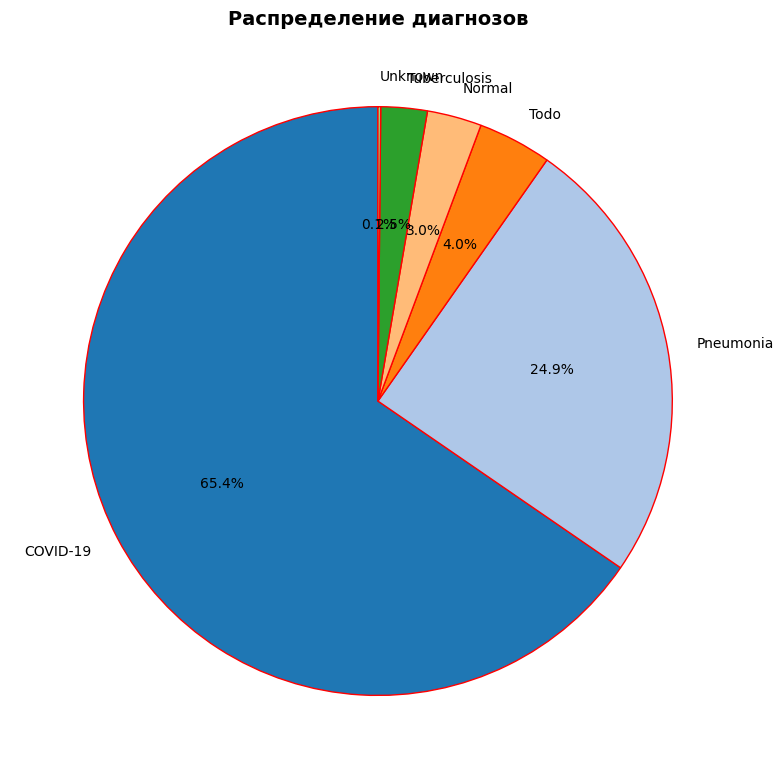

In [43]:
plt.figure(figsize=(8, 8))

#  pie chart
colors = plt.get_cmap("tab20").colors
view['finding_unified'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'red'},
    textprops={'fontsize': 10}
)

plt.ylabel('')
plt.title('Распределение диагнозов', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


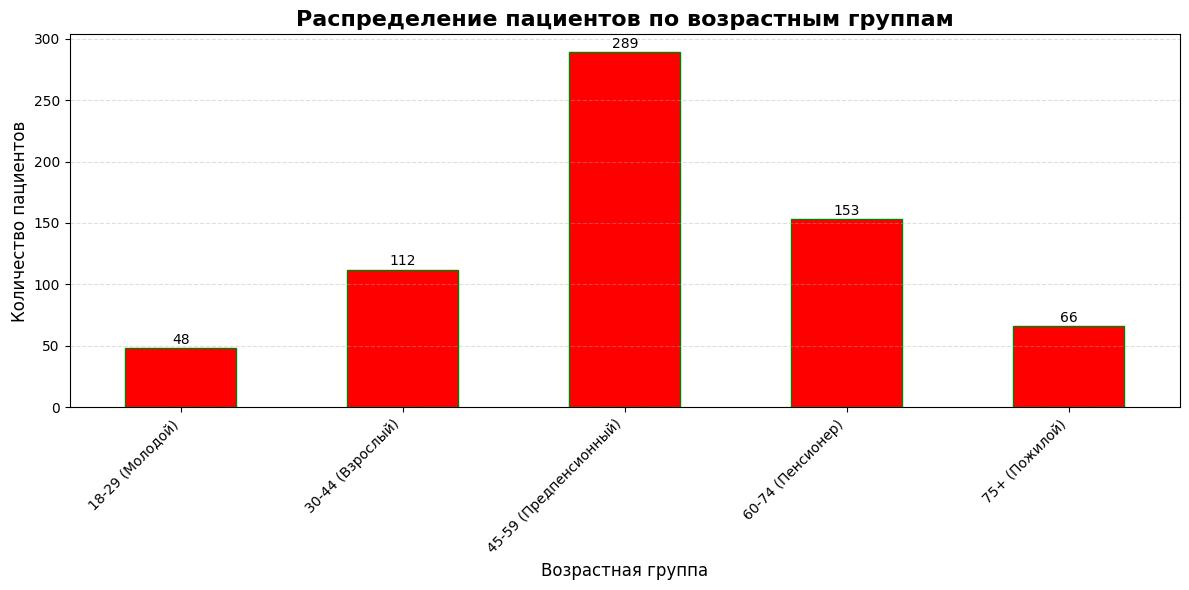

In [45]:
plt.figure(figsize=(12, 6))

# Подсчет и сортировка по возрастным группам
age_group_counts = view['age_category'].value_counts().sort_index()

# Построение столбчатой диаграммы
bars = age_group_counts.plot(
    kind='bar',
    color='red',
    edgecolor='green'
)

# Подписи и стиль
plt.title('Распределение пациентов по возрастным группам', fontsize=16, fontweight='bold')
plt.xlabel('Возрастная группа', fontsize=12)
plt.ylabel('Количество пациентов', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Добавление значений над столбцами
for bar in bars.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()


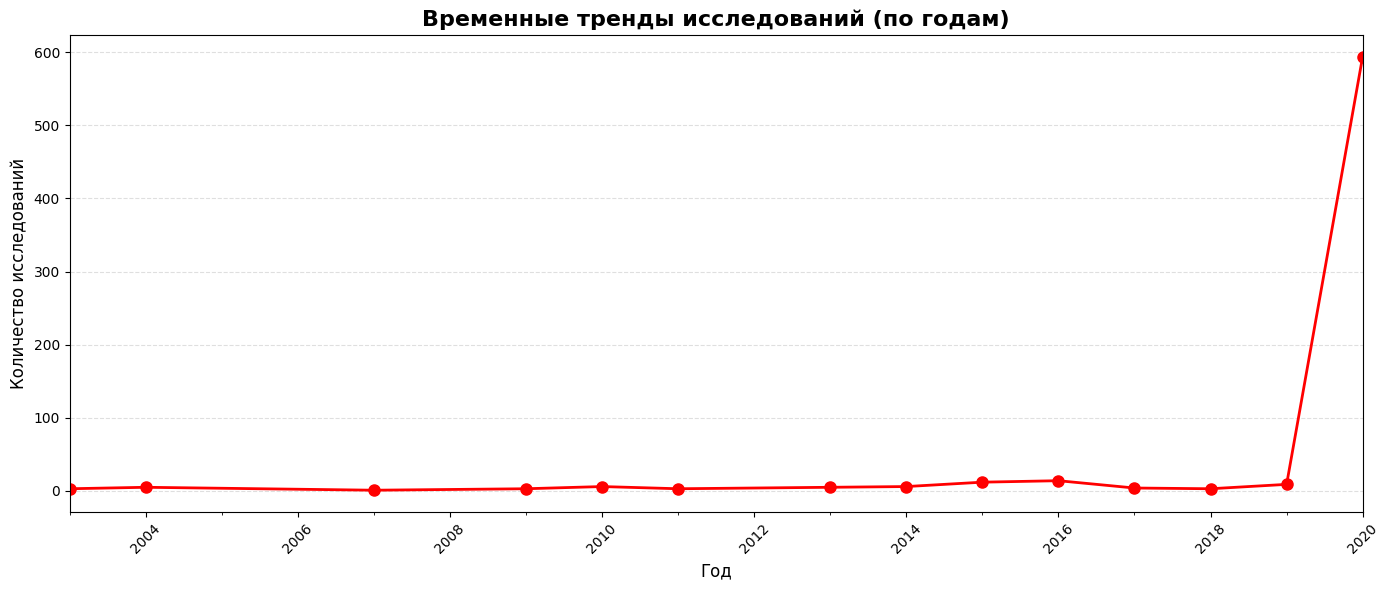

In [46]:
# Преобразуем в datetime
view['date_correct'] = pd.to_datetime(view['date_correct'])

# Группировка по годам
year_data = view.groupby(view['date_correct'].dt.to_period('Y')).size()

plt.figure(figsize=(14, 6))

year_data.plot(
    kind='line',
    marker='o',
    linewidth=2,
    markersize=8,
    color='red'
)

plt.title('Временные тренды исследований (по годам)', fontsize=16, fontweight='bold')
plt.xlabel('Год', fontsize=12)
plt.ylabel('Количество исследований', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


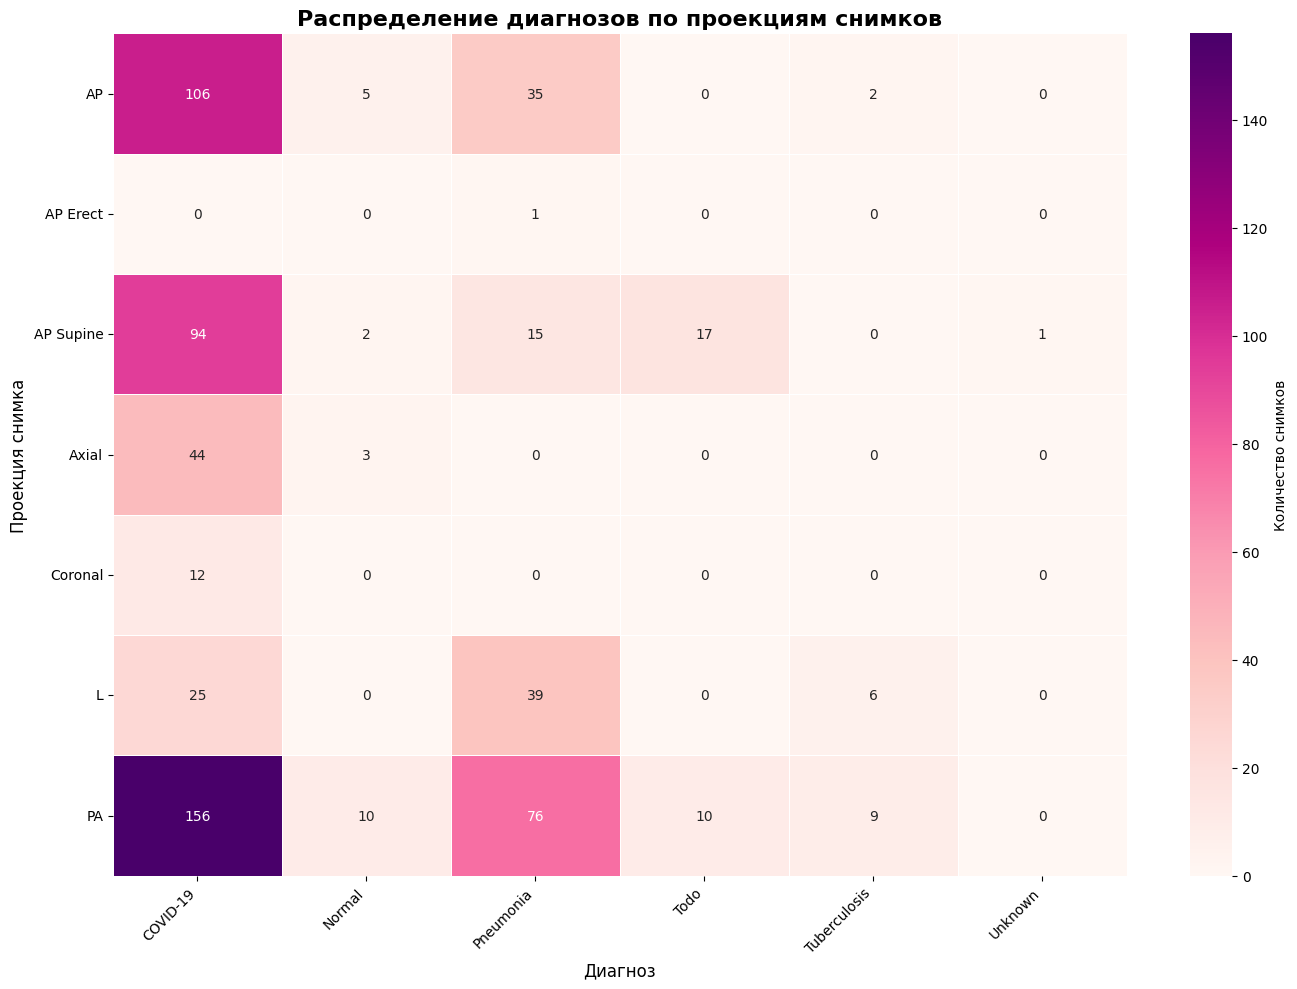

In [48]:
# Подготовка данных для heatmap
heatmap_data = view.groupby(['view', 'finding_unified']).size().unstack(fill_value=0)

# Отбираем топ-10 проекций по количеству снимков
top_views = view['view'].value_counts().head(10).index
heatmap_data = heatmap_data.loc[heatmap_data.index.isin(top_views)]

plt.figure(figsize=(14, 10))


sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='d',
    cmap='RdPu',
    linewidths=0.5,
    cbar_kws={'label': 'Количество снимков'},
    square=False
)


plt.title('Распределение диагнозов по проекциям снимков', fontsize=16, fontweight='bold')
plt.xlabel('Диагноз', fontsize=12)
plt.ylabel('Проекция снимка', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()